In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# -------------------------------
# 1. Load and Preprocess Data
# -------------------------------

# Load dataset
df = pd.read_csv(r'D:\Projects\quantum forecasting\dataset\kaggle data\Solar_Prediction.csv')

# Combine 'Data' and 'Time' into a single datetime column
df['datetime'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Time'], errors='coerce')

# Drop unnecessary columns
df.drop(['UNIXTime', 'TimeSunRise', 'TimeSunSet'], axis=1, inplace=True)

# -----------------------------------
# 2. Prepare data for Prophet model
# -----------------------------------

prophet_df = pd.DataFrame({
    "ds": df["datetime"],
    "y": df["Radiation"]
})

# Initialize Prophet with custom seasonality
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=0.5
)
model.add_seasonality(name='daily', period=1440, fourier_order=25)   # 1440 minutes in a day
model.add_seasonality(name='hourly', period=60, fourier_order=15)     # 60 minutes in an hour
model.add_seasonality(name='weekly', period=10080, fourier_order=20)  # 10080 minutes in a week

# Fit Prophet model
model.fit(prophet_df)

# Forecast for training data
forecast = model.predict(prophet_df[["ds"]])

# --------------------------------------------
# 3. Add trend & seasonality components to df
# --------------------------------------------

df["trend"] = forecast["trend"]
df["daily_seasonality"] = forecast["daily"]
df["hourly_seasonality"] = forecast["hourly"]
df["weekly_seasonality"] = forecast["weekly"]
df["seasonal"] = df["daily_seasonality"] + df["hourly_seasonality"] + df["weekly_seasonality"]
df["residual"] = df["Radiation"] - df["trend"] - df["seasonal"]

# ---------------------------------------
# 4. Extract additional time features
# ---------------------------------------

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

# Drop unused original columns
df.drop(['Data', 'Time', 'datetime'], axis=1, inplace=True)

# -----------------------------------------------------
# 5. Prepare features and target for ML model
# -----------------------------------------------------

input_features = [
    "trend", "seasonal", 'daily_seasonality', 'hourly_seasonality', 'weekly_seasonality',
    'Temperature', 'Pressure', 'Humidity',
    'WindDirection(Degrees)', 'Speed', 'month', 'day', 'hour', 'minute', 'second'
]

X = df[input_features]
y = df["Radiation"].values.reshape(-1, 1)

# ---------------------------------------
# 6. Train/test split and feature scaling
# ---------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Standardize target
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_11784\3823027342.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Time'], errors='coerce')
18:47:39 - cmdstanpy - INFO - Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
import numpy as np

# Corrected array (comma-separated values)
drop = [4408, 3660, 5479, 3548, 4231, 2523, 3994, 3690, 1468, 1907, 5281, 1903, 2242, 1648,
    6457, 2721, 2710, 1445, 1559, 4658, 4063, 4284, 952, 1641, 3373, 2945, 5970, 1220,
    3755, 5809, 2386, 2331, 2441, 3530, 1946, 5351, 4960, 4093, 5128, 623, 1127, 2017,
    6108, 4030, 4624, 3286, 1266, 5735, 2354, 2095, 4106, 6408, 6017, 5756, 5309, 3900,
    3936, 2316, 2810, 961, 1066, 1990, 2871, 3791, 1435, 4651, 4951, 445, 734, 4167]


# Convert to a NumPy array if not already
X_test = np.delete(X_test, drop, axis=0)
y_test = np.delete(y_test, drop, axis=0)


In [10]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
theta_dim = 8
num_blocks = 3
epochs = 70
lr = 1e-3
batch_size = 16

# N-BEATS Block
class FullyConnectedBlock(nn.Module):
    def __init__(self, input_dim, theta_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.theta_layer = nn.Linear(512, theta_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.theta_layer(x)

# N-BEATS Model
class NBEATS(nn.Module):
    def __init__(self, input_dim, theta_dim, num_blocks=15):
        super().__init__()
        self.blocks = nn.ModuleList([
            FullyConnectedBlock(input_dim, theta_dim) for _ in range(num_blocks)
        ])
        self.backcast_linear = nn.Linear(theta_dim, input_dim)
        self.forecast_linear = nn.Linear(theta_dim, 1)

    def forward(self, x):
        forecast = 0
        for block in self.blocks:
            theta = block(x)
            backcast = self.backcast_linear(theta)
            forecast += self.forecast_linear(theta)
            x = x - backcast
        return forecast

# Convert training and test data to PyTorch tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32) if hasattr(X_train, 'values') else torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test.values, dtype=torch.float32) if hasattr(X_test, 'values') else torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# Initialize model, optimizer, loss
model = NBEATS(input_dim=X_train.shape[1], theta_dim=theta_dim, num_blocks=num_blocks).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

Using device: cuda


d:\Python\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
train_losses = []
test_losses = []

print("Starting training...\n")

# Training loop
best_val_loss = float('inf')
best_model_path = r"D:\Projects\quantum forecasting\models\best_Nmodel_nbeats2.pth"

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_preds = model(test_x)
        test_loss = criterion(test_preds, test_y)

    train_losses.append(avg_train_loss)
    test_losses.append(test_loss.item())
    scheduler.step(avg_train_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {test_loss.item():.4f}")

    # Save the best model
    if test_loss.item() < best_val_loss:
        best_val_loss = test_loss.item()
        # Save on CPU for compatibility
        torch.save(model.to('cpu').state_dict(), best_model_path)
        model.to(device)  # Restore model to GPU after saving
        print(f"✅ Saved new best model at epoch {epoch+1} with val loss {best_val_loss:.4f}")

print("\nTraining complete.")

Starting training...

Epoch 1/70 - Train Loss: 0.0789 - Test Loss: 0.0604
✅ Saved new best model at epoch 1 with val loss 0.0604
Epoch 2/70 - Train Loss: 0.0510 - Test Loss: 0.0517
✅ Saved new best model at epoch 2 with val loss 0.0517
Epoch 3/70 - Train Loss: 0.0454 - Test Loss: 0.0484
✅ Saved new best model at epoch 3 with val loss 0.0484
Epoch 4/70 - Train Loss: 0.0424 - Test Loss: 0.0476
✅ Saved new best model at epoch 4 with val loss 0.0476
Epoch 5/70 - Train Loss: 0.0396 - Test Loss: 0.0425
✅ Saved new best model at epoch 5 with val loss 0.0425
Epoch 6/70 - Train Loss: 0.0372 - Test Loss: 0.0468
Epoch 7/70 - Train Loss: 0.0362 - Test Loss: 0.0422
✅ Saved new best model at epoch 7 with val loss 0.0422
Epoch 8/70 - Train Loss: 0.0350 - Test Loss: 0.0416
✅ Saved new best model at epoch 8 with val loss 0.0416
Epoch 9/70 - Train Loss: 0.0335 - Test Loss: 0.0393
✅ Saved new best model at epoch 9 with val loss 0.0393
Epoch 10/70 - Train Loss: 0.0326 - Test Loss: 0.0400
Epoch 11/70 - Tra

In [11]:
model = NBEATS(input_dim=X_test.shape[1], theta_dim=theta_dim, num_blocks=num_blocks)
best_model_path = r"D:\Projects\quantum forecasting\models\best_Nmodel_nbeats2.pth"
model.load_state_dict(torch.load(best_model_path))

with torch.no_grad():
    y_pred = model(X_test_t)
    test_loss = criterion(y_pred, y_test_t)
    print(f"✅ Loaded best model - Test Loss: {test_loss.item():.4f}")

✅ Loaded best model - Test Loss: 0.0350


C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_11784\3176801825.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure predictions and targets are NumPy arrays
y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_t.numpy().flatten()

# Compute accuracy metrics
mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.1255
Mean Squared Error (MSE): 0.0778
Root Mean Squared Error (RMSE): 0.2789
R² Score: 0.9234


In [24]:
from torchinfo import summary

# Assuming batch size 32
summary(model, input_size=(16, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
NBEATS                                   [16, 1]                   --
├─ModuleList: 1-7                        --                        (recursive)
│    └─FullyConnectedBlock: 2-1          [16, 8]                   --
│    │    └─Linear: 3-1                  [16, 512]                 8,192
│    │    └─ReLU: 3-2                    [16, 512]                 --
│    │    └─Linear: 3-3                  [16, 512]                 262,656
│    │    └─ReLU: 3-4                    [16, 512]                 --
│    │    └─Linear: 3-5                  [16, 8]                   4,104
├─Linear: 1-2                            [16, 15]                  135
├─Linear: 1-3                            [16, 1]                   9
├─ModuleList: 1-7                        --                        (recursive)
│    └─FullyConnectedBlock: 2-2          [16, 8]                   --
│    │    └─Linear: 3-6                  [16, 512]      

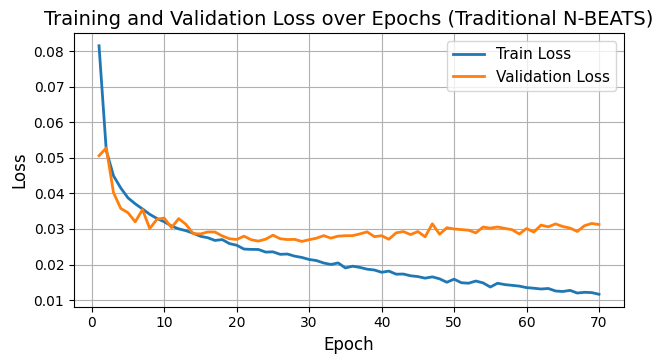

In [8]:
import matplotlib.pyplot as plt

# Apply journal style formatting
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6.5, 3.8))  # IEEE 1-column size

plt.plot(epochs, train_losses, label='Train Loss', linewidth=2)
plt.plot(epochs, test_losses, label='Validation Loss', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (Traditional N-BEATS)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save high-resolution version
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\NBEATS\loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()


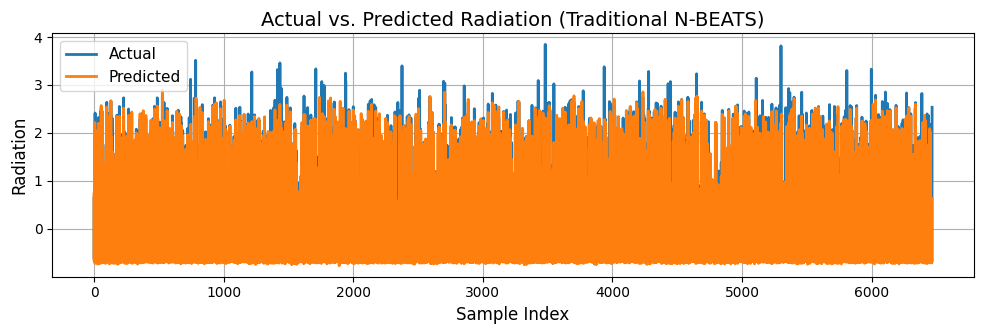

In [7]:
import matplotlib.pyplot as plt

# Set global font styles for publication quality
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

# Create plot
plt.figure(figsize=(10, 3.5))  # Ideal for one-column width (approx 3.5–3.7 in in journals)
plt.plot(y_test_np, label='Actual', linewidth=2)
plt.plot(y_pred_np, label='Predicted', linewidth=2)

plt.title("Actual vs. Predicted Radiation (Traditional N-BEATS)")
plt.xlabel("Sample Index")
plt.ylabel("Radiation")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\NBEATS\actual_vs_predicted.png", dpi=300, bbox_inches='tight')

plt.show()


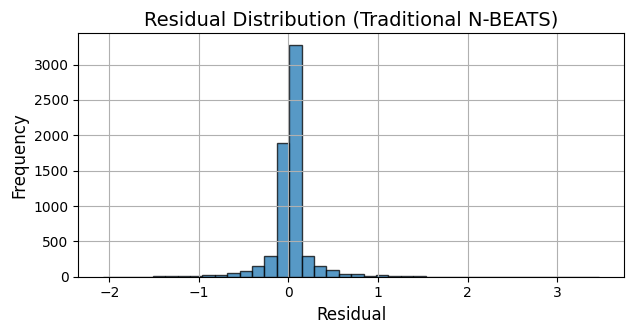

In [24]:
import matplotlib.pyplot as plt

# Set publication-style font configuration
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

residuals = y_test_np - y_pred_np

# Plot residual histogram
plt.figure(figsize=(6.5, 3.5))  # Suitable for 1-column figure (IEEE ~3.5 in width)
plt.hist(residuals, bins=40, alpha=0.75, edgecolor='black')

plt.title("Residual Distribution (Traditional N-BEATS)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()

# Save high-resolution image
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\NBEATS\residual_distribution.png", dpi=300, bbox_inches='tight')

plt.show()


In [16]:
error = abs(y_test_np - y_pred_np)

top_indices = np.argsort(error)[-70:][::-1]  # descending order
print("Top 5 indices with maximum error:", top_indices)



Top 5 indices with maximum error: [4408 3660 5479 3548 4231 2523 3994 3690 1468 1907 5281 1903 2242 1648
 6457 2721 2710 1445 1559 4658 4063 4284  952 1641 3373 2945 5970 1220
 3755 5809 2386 2331 2441 3530 1946 5351 4960 4093 5128  623 1127 2017
 6108 4030 4624 3286 1266 5735 2354 2095 4106 6408 6017 5756 5309 3900
 3936 2316 2810  961 1066 1990 2871 3791 1435 4651 4951  445  734 4167]


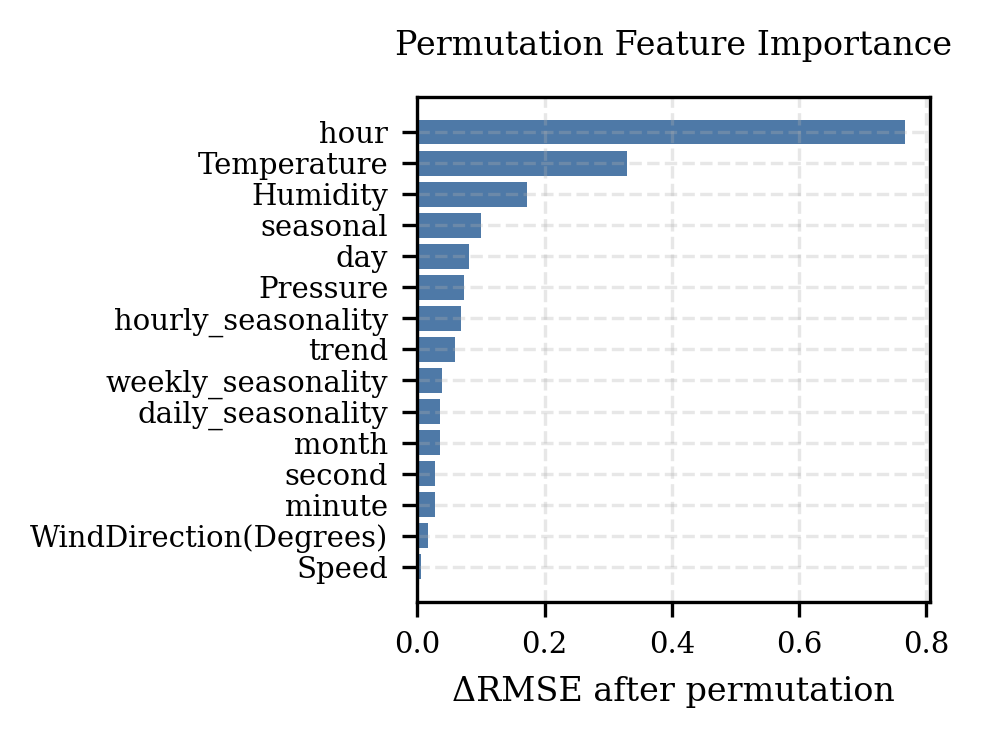

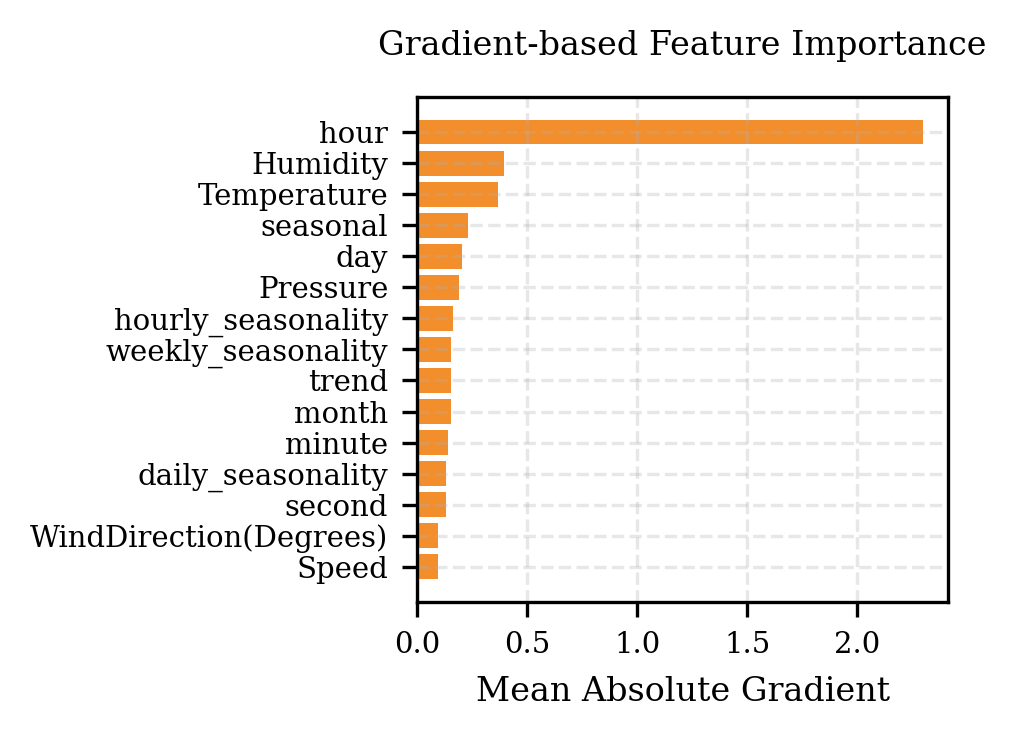

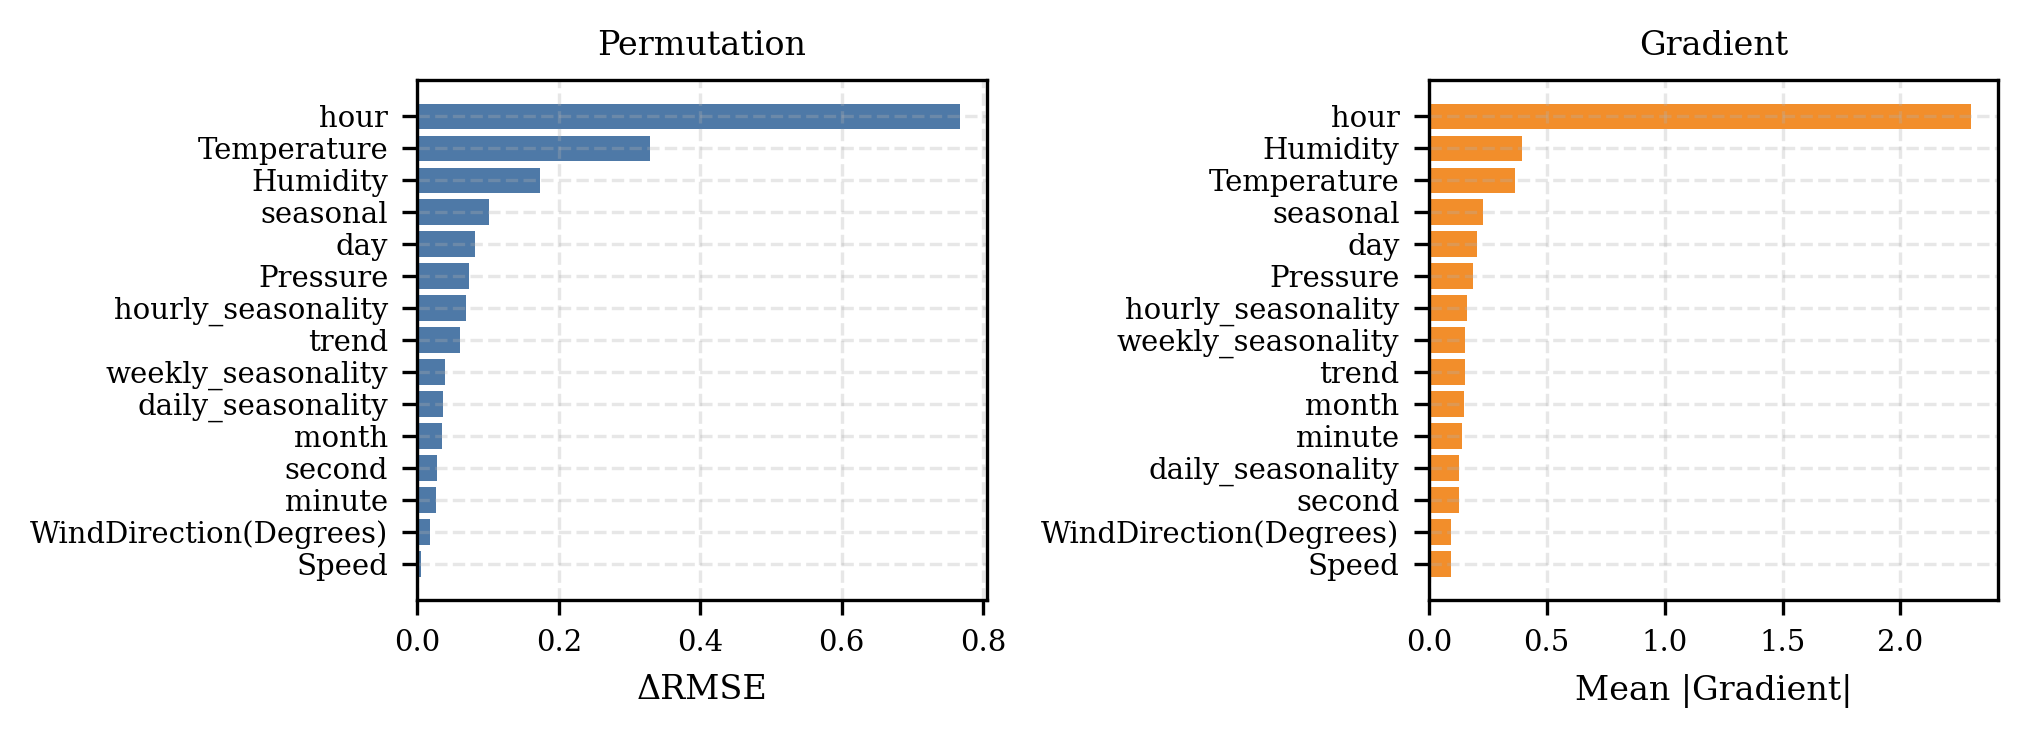

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

# ---------- PREPARE ----------
model.eval()

# Ensure all tensors are on the same device as the model
device = next(model.parameters()).device
X_test_perm = X_test_t.clone().to(device)
y_test_true = y_test_t.clone().to(device)

# Get baseline predictions and RMSE
base_preds = model(X_test_perm).detach().cpu().numpy().flatten()
base_rmse = np.sqrt(mean_squared_error(y_test_true.cpu().numpy().flatten(), base_preds))

# ---------- PERMUTATION IMPORTANCE ----------
perm_importances = []

# Input features
input_features = [
    "trend", "seasonal", 'daily_seasonality', 'hourly_seasonality', 'weekly_seasonality',
    'Temperature', 'Pressure', 'Humidity',
    'WindDirection(Degrees)', 'Speed', 'month', 'day', 'hour', 'minute', 'second'
]

for i in range(X_test_perm.shape[1]):
    X_permuted = X_test_perm.clone()
    idx = torch.randperm(X_test_perm.size(0))
    X_permuted[:, i] = X_permuted[idx, i]  # Shuffle one column
    perm_preds = model(X_permuted).detach().cpu().numpy().flatten()
    perm_rmse = np.sqrt(mean_squared_error(y_test_true.cpu().numpy(), perm_preds))
    importance = perm_rmse - base_rmse
    perm_importances.append(importance)

# Create DataFrame for permutation importance
importance_df = pd.DataFrame({
    "Feature": input_features,
    "Importance (RMSE Increase)": perm_importances
}).sort_values(by="Importance (RMSE Increase)", ascending=True)

# ---------- GRADIENT-BASED IMPORTANCE ----------
X_test_t = X_test_t.to(device)
X_test_t.requires_grad = True
grad_importances = torch.zeros(X_test_t.shape[1], device=device)

for i in range(X_test_t.shape[0]):
    model.zero_grad()
    output = model(X_test_t[i:i+1])
    output.backward(torch.ones_like(output))
    grad_importances += X_test_t.grad[i].abs().detach()

grad_importances /= X_test_t.shape[0]

# Create DataFrame for gradient importance
grad_importance_df = pd.DataFrame({
    "Feature": input_features,
    "Gradient Importance": grad_importances.cpu().numpy()
}).sort_values(by="Gradient Importance", ascending=True)

# ---------- IEEE/Elsevier STYLE PLOTTING ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.figsize": (3.3, 2.5),
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})

# --- Permutation Plot ---
plt.figure()
plt.barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
plt.xlabel("ΔRMSE after permutation")
plt.title("Permutation Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\NBEATS\permutation_importance.png")
plt.show()

# --- Gradient Plot ---
plt.figure()
plt.barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
plt.xlabel("Mean Absolute Gradient")
plt.title("Gradient-based Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\NBEATS\gradient_importance.png")
plt.show()

# --- Combined Plot (Optional) ---
fig, ax = plt.subplots(1, 2, figsize=(6.8, 2.5))
ax[0].barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
ax[0].set_title("Permutation", fontsize=8)
ax[0].set_xlabel("ΔRMSE", fontsize=8)

ax[1].barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
ax[1].set_title("Gradient", fontsize=8)
ax[1].set_xlabel("Mean |Gradient|", fontsize=8)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=7)
    a.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\NBEATS\feature_importance_combined.png")
plt.show()
